In [22]:
%matplotlib inline

import os
import cv2
import imp
import glob
import scipy
import numpy as np
import pandas as pd
from numpy import pi
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.gridspec as gridspec

from sklearn import svm
report_dir = '../report'

In [2]:
df = pd.DataFrame(columns={'label', 'img'})
positives = [{'label':1, 'img':cv2.imread(path)} for path in glob.glob('data/positives/*.png')]
negatives = [{'label':0, 'img':cv2.imread(path)} for path in glob.glob('data/negatives/*.png')]
df = df.append(positives, ignore_index=True)
df = df.append(negatives, ignore_index=True)

In [3]:
df['edges'] = df.img.apply(lambda img: cv2.Canny(img,100,200))
df['mean_edges'] = df.edges.apply(lambda img: np.mean(img))
for i, c in enumerate(['b', 'r', 'g']):
    df['mean_%s' % c] = df.img.apply(lambda img: np.mean(img[:, :, i]))
    df['max_%s' % c] = df.img.apply(lambda img: np.max(img[:, :, i]))
    df['min_%s' % c] = df.img.apply(lambda img: np.min(img[:, :, i]))
    df['delta_%s' % c] = np.abs(df['min_%s' % c] - df['max_%s' % c]) 
    df['mean_%s' % c] = df.img.apply(lambda img: np.mean(img[:, :, i]))
    df['std_%s' % c] = df.img.apply(lambda img: np.std(img[:, :, i]))


In [4]:
features = ['mean_edges', 'delta_r', 'std_r', 'std_g', 'std_b']
#features = ['delta_r', 'std_r', 'std_g', 'std_b']
df[features].sample(15)

,mean_edges,delta_r,std_r,std_g,std_b
58,0.000000,68,17.356813,14.811284,13.265838
4,32.760417,128,22.745217,17.714692,10.934814
7,55.338542,151,30.648242,20.340835,15.717565
12,26.562500,134,31.808393,22.333715,13.180438
8,50.026042,131,24.111407,19.262619,8.548447
45,0.000000,74,17.005151,13.496268,14.869367
59,0.000000,67,10.729608,10.199401,6.600671
25,54.895833,134,22.709064,19.454480,12.169499
21,41.614583,123,23.388616,19.339545,8.617296
23,77.031250,130,27.593299,25.211051,12.701569


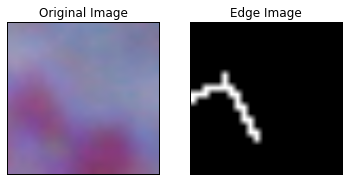

mean_edges    10.1823
delta_r            97
std_r         24.9102
std_g         18.1717
std_b         7.91388
Name: 35, dtype: object


In [5]:
funf = df[(df.mean_edges > 0) & (df.mean_edges < 20)].iloc[0]

plt.subplot(121),plt.imshow(funf.img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(funf.edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

print funf[features]

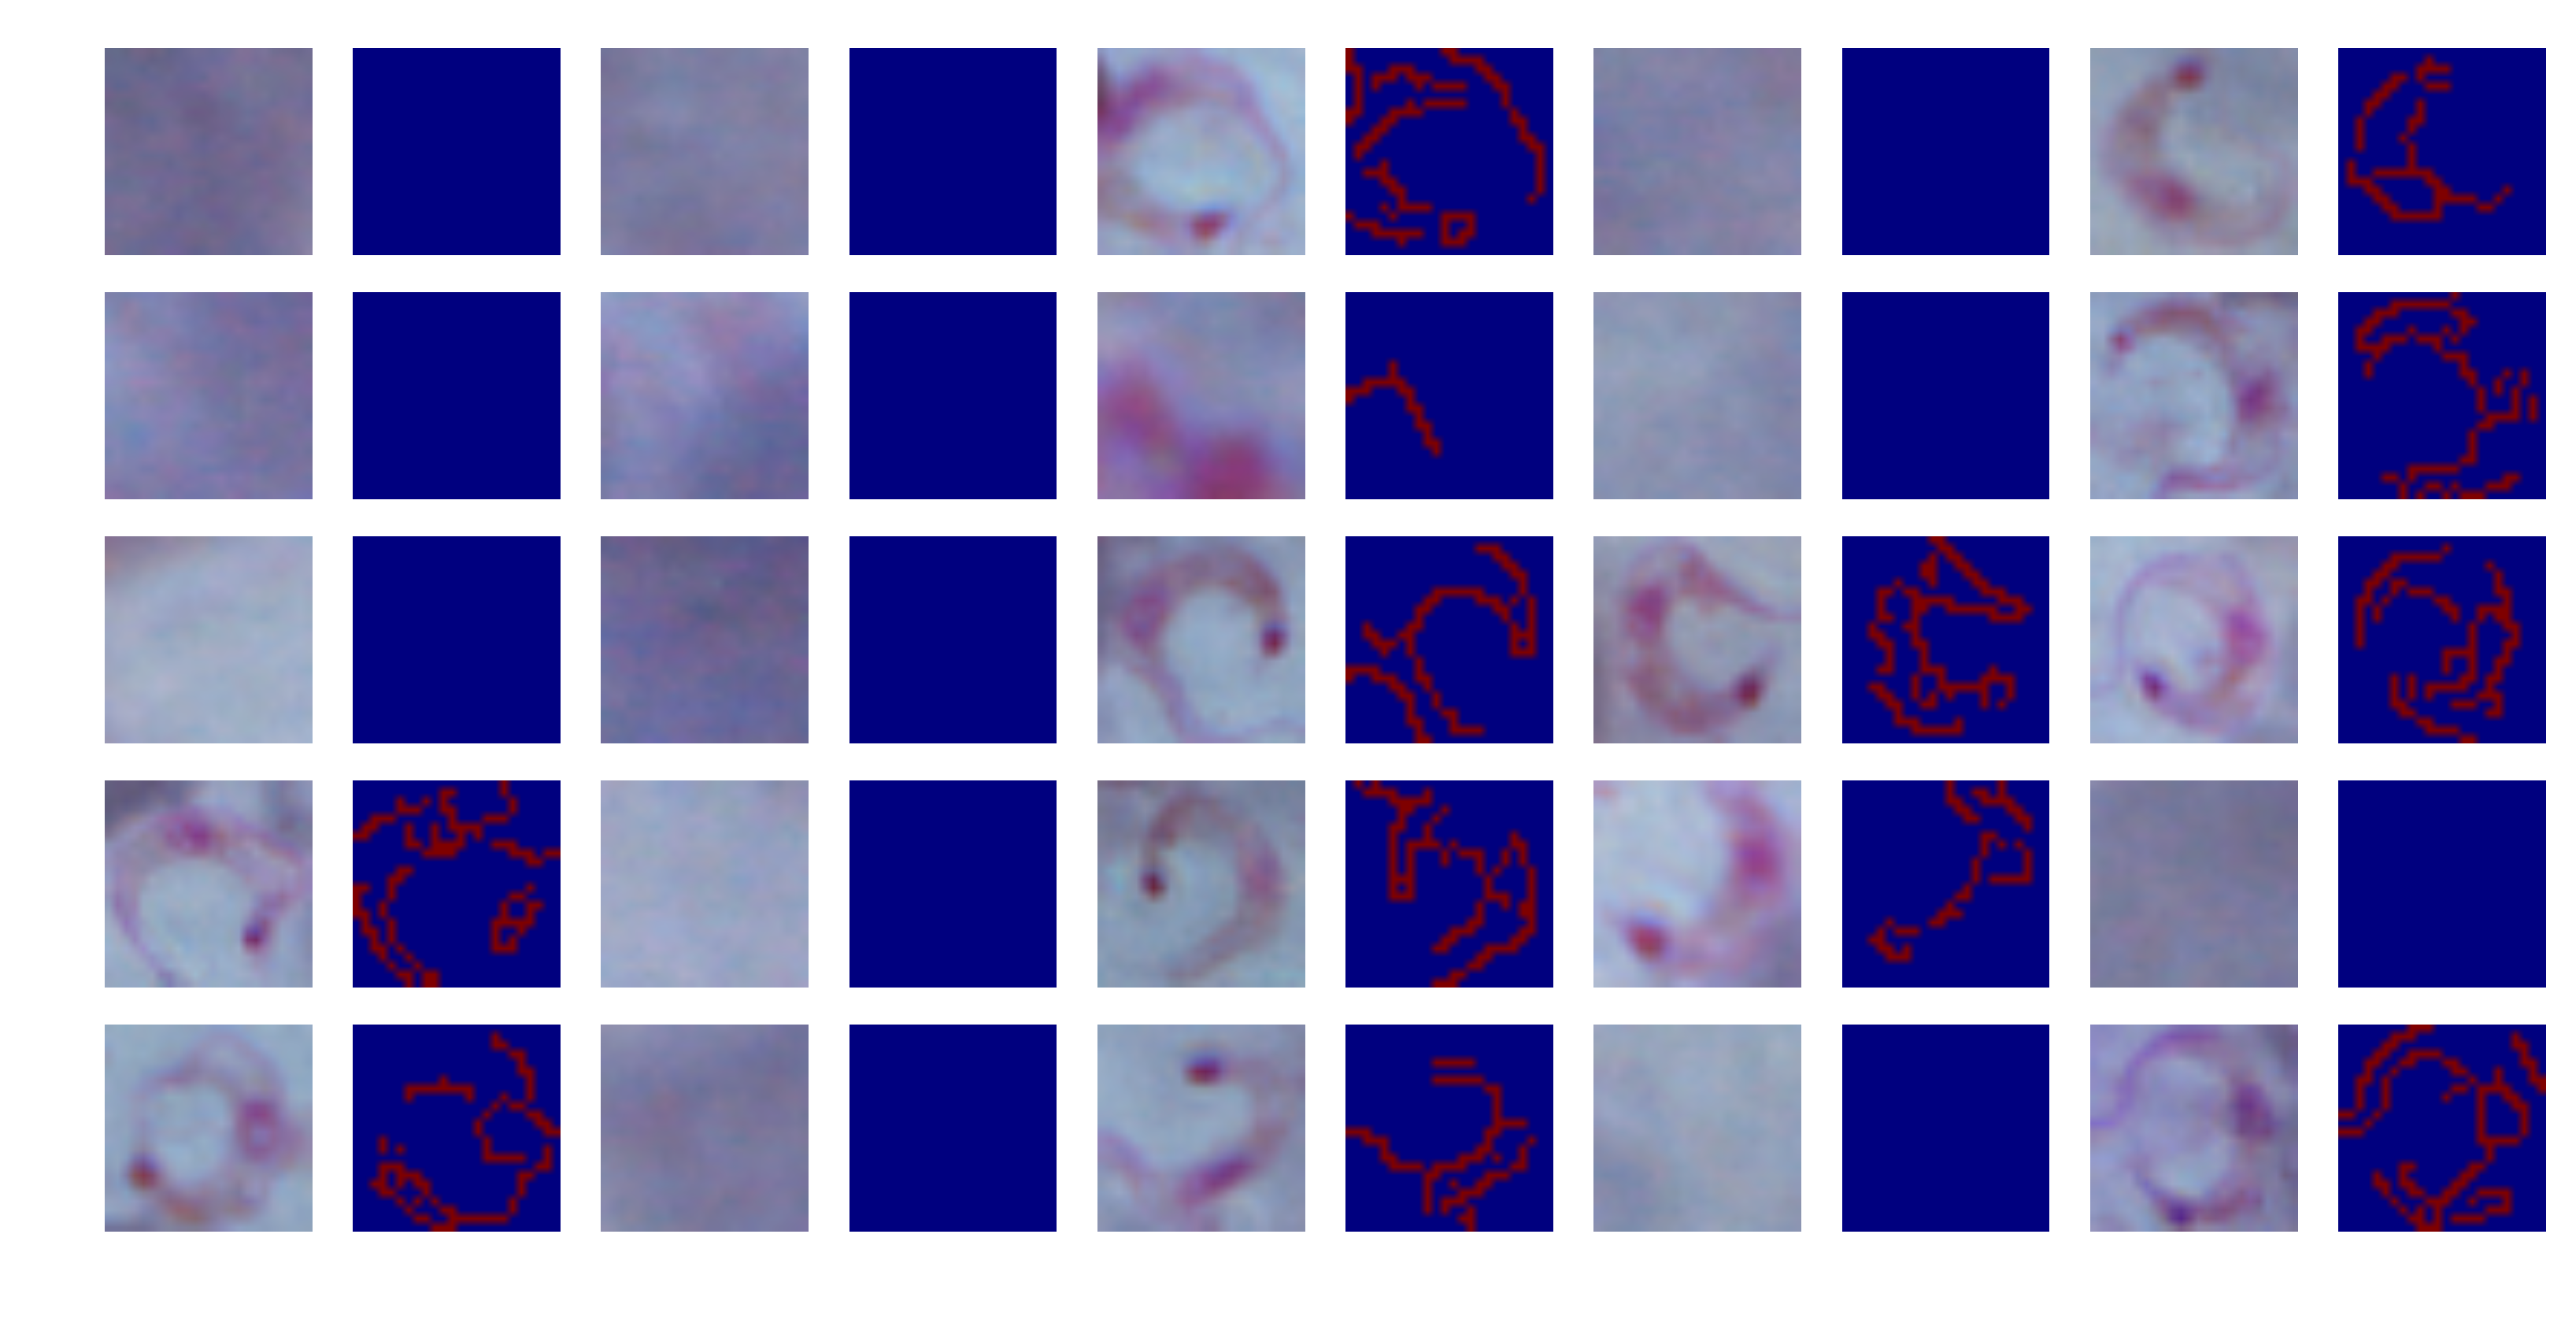

In [6]:
rows = 5
cols = 5
fig, ax = plt.subplots(num=None, figsize=(2*rows, cols), dpi=400, facecolor='w', edgecolor='k')
gs = gridspec.GridSpec(rows, 2*cols)
ax = [plt.subplot(gs[i]) for i in range(2*rows*cols)]
gs.update(hspace=0)
for i, (_, row) in enumerate(df.sample(rows*cols).iterrows()):
    ax[2*i].imshow(row.img)
    ax[2*i+1].imshow(row.edges)
    ax[2*i+1].axis('off')
    ax[2*i].axis('off')
plt.show()

In [58]:
def split_df():
    msk = np.random.rand(len(df)) < 0.8
    train, test= df[msk], df[~msk]
    
    X_train = train[features].as_matrix()
    y_train = train.label.as_matrix()

    X_test = test[features].as_matrix()
    y_test = test.label.as_matrix()
    return X_train, y_train, X_test, y_test

trial_count = 250
kernels = ['linear', 'poly', 'sigmoid', 'rbf']
score = {'train':{k:[] for k in kernels}, 'test':{k:[] for k in kernels}}
for k in kernels:
    for i in range(trial_count):
        X_train, y_train, X_test, y_test = split_df()
        clf = svm.SVC(kernel=k)
        clf.fit(X_train, y_train) 
        
        train_error = clf.score(X_train, y_train)
        test_error = clf.score(X_test, y_test)
        score['train'][k].append(train_error) 
        score['test'][k].append(test_error)

        #print 'testing error: {:0.4f}'.format(test_error)

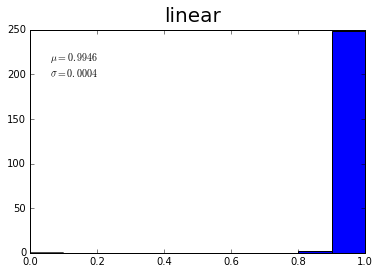

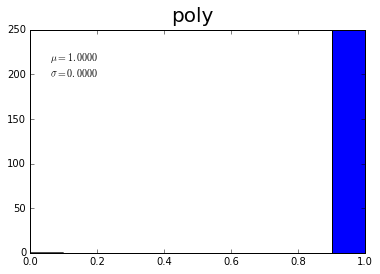

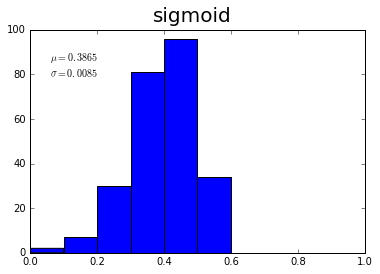

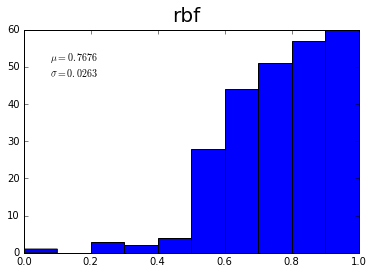

In [59]:
for k in kernels:
    trials = score['test'][k] 
    summary = scipy.stats.describe(trials)
    fig, ax = plt.subplots(num=None, facecolor='w', edgecolor='k')
    ax.hist(trials, bins=np.arange(0, 1.1, 0.1)) 
    
    fig.suptitle(k, fontsize=20)
    a = r'$\mu = {0:0.4f}$'.format(summary.mean) + '\n' + \
        r'$\sigma = {0:0.4f}$'.format(summary.variance)
    ax.annotate(a, xy=(50, 200), xycoords='figure points')
